In [1]:
import matplotlib.pyplot as plt
import numpy as np

from checking_tools import checkLabels, checkNormals
from Trefft_tools import TrefftzSpace, TrefftzFunction,  AssembleRHS, AssembleMatrix, AssembleGreenRHS
from geometry_tools import Edge
from meshes import testMesh, toyMesh, waveguideMesh, GradientMesh
from meshes import ScattererType

In [2]:
R = 10.
H = 1.
rad = 0.3

c = (0,0.0)

scatterer_type = ScattererType.PENETRABLE

quad = False
Omega = waveguideMesh(R = R, h_max=2*H/3,rad = rad, c=c,  scatterer_type=scatterer_type)
Omega = GradientMesh(h_min=0.05)

# Omega = testMesh( h_max= 2*H/3, quad=quad)
# #Omega = toyMesh(quad=quad)

In [3]:
Edges = [ Edge(Omega, e, c)  for e in Omega.edges ]

Checking the orientation of the labels...

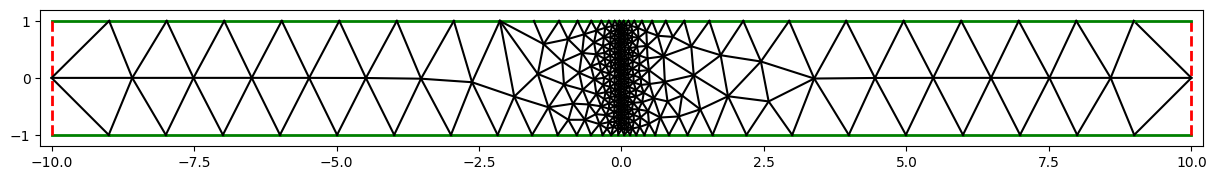

In [4]:
checkLabels(Edges)

and the orientation of the normals...

(-0.44999999999999996, 0.44999999999999996)

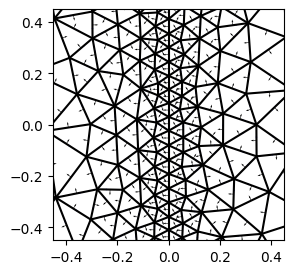

In [5]:
checkNormals(Edges)
plt.xlim([-1.5*rad,1.5*rad])
plt.ylim([c[1] - 1.5*rad, c[1]+1.5*rad])

and the definition of the "plus" and "minus" quantities...

In [6]:
  # checkPlusMinus(Edges, Baricenters) 

In [7]:
kappa_e = 8.
kappa_i = 12.


In [8]:
# #optimal angle for mode "t" : th = arcsin( lambda /  (2H)) 
# t = 2
# dth = np.arcsin( t*np.pi / (kappa_e*H))
# # optimal number of waves for mode "t":
# Nth = int(2*np.pi / dth)
# Nth 

In [9]:
Nth = 15
th = np.e/10
th = 0.
V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )


In [10]:
sparse = True

In [11]:
NP = 20
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A = AssembleMatrix(V, Edges, Np=NP, a=a, b=b, d_1=d_1, d_2=d_2)
NDOF = A.shape[0]


In [12]:
print(f'{NDOF=}, {np.count_nonzero(A.toarray())/NDOF**2=}')

NDOF=8925, np.count_nonzero(A.toarray())/NDOF**2=0.006529105759951039


In [13]:
# Ncond = np.linalg.cond(A.toarray())
Ncond = -1
Ncond 

-1

In [14]:
# conds_00 = []
# conds_05 = []
# for Nth in range(1,12):
#     th = np.pi/np.e
#     V = TrefftzSpace(Omega, Nth, {"Omega_i" : kappa_i , "Omega_e" : kappa_e}, th )
#     NP = 20
#     A = AssembleMatrix(V, Edges, Np=NP, d_2=0., fullsides=fullsides, sparse=True)
#     conds_00.append(np.linalg.cond(A.toarray()))
#     A = AssembleMatrix(V, Edges, Np=NP, d_2=0.5, fullsides=fullsides, sparse=True)
#     conds_05.append(np.linalg.cond(A.toarray()))

# plt.plot(range(1,12),conds_00, label='d=00')
# plt.plot(range(1,12),conds_05, label='d=0.5')
# plt.legend()

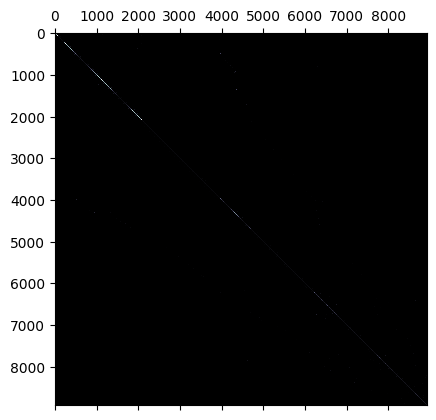

In [15]:
if sparse:
    plt.matshow(np.abs(A.toarray()), cmap='bone')
else:
    plt.matshow(np.abs(A), cmap='bone')
# for y_ in range(0,NDOF,Nth):
#     plt.hlines(y=y_,xmin=0,xmax=NDOF,colors='r')
#     plt.vlines(x=y_,ymin=0,ymax=NDOF,colors='r')


In [16]:
match scatterer_type:
    case ScattererType.SOUND_SOFT | ScattererType.PENETRABLE:
        t = 2
        B = AssembleRHS(V, Edges, kappa_e, H, d_2=d_2, t=t)
    case ScattererType.GREEN_FUNC:
        B = AssembleGreenRHS(V, Edges, kappa_e, H, a=a, y0=c[1])

In [17]:
#DOFs = np.linalg.solve(A,B)
from scipy.sparse.linalg import bicgstab 
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
# DOFs, _ = bicgstab(A,B)
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

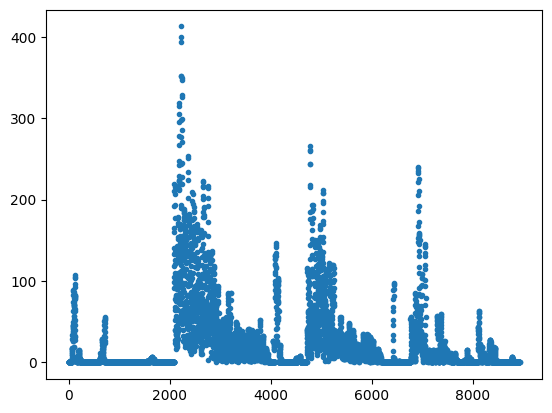

In [18]:
plt.plot(np.abs(DOFs),'.')

In [19]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(-H,H,Ny)
X, Y = np.meshgrid(x,y)

# Z = np.reshape(f(X.ravel(), Y.ravel()), [Ny,Nx]) FIX THIS, EVALUATION SHOULD BE VECTORIZED

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


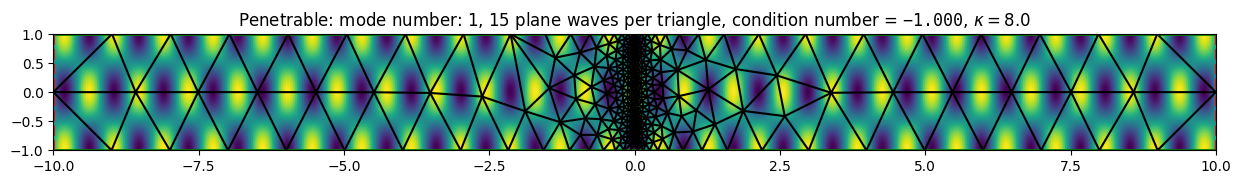

In [21]:
_, ax = plt.subplots( figsize=(15,3))

ax.imshow(np.real(u_Trefft), origin="lower", extent=[-R,R,-H,H])
match scatterer_type:
    case ScattererType.SOUND_HARD | ScattererType.SOUND_SOFT | ScattererType.GREEN_FUNC:
        kwargs = {"facecolor" : "grey", "edgecolor" : "black", "linewidth" : 3}
    case ScattererType.PENETRABLE:
        kwargs = {"facecolor" : "none", "edgecolor" : "black", "linewidth" : 3}
from matplotlib.patches import Circle


checkLabels(Edges, ax)
ax.axis('square')
ax.set_xlim([-R,R])
ax.set_ylim([-H,H])

match scatterer_type:
    case ScattererType.PENETRABLE:
        ax.set_title(f'Penetrable: mode number: {t}, {Nth} plane waves per triangle, condition number = $\\mathtt{{ {Ncond: .3f} }}$, $\\kappa={kappa_e:.1f}$')
    case ScattererType.SOUND_SOFT:
         ax.set_title(f'Sound-soft: mode number: {t}, {Nth} plane waves per triangle, condition number = $\\mathtt{{ {Ncond: .3f} }}$, $\\kappa={kappa_e:.1f}$')
    case ScattererType.GREEN_FUNC:
        ax.set_title(f'Green function case, {Nth} plane waves per triangle, condition number =   $\\mathtt{{ {Ncond: .3f} }}$, $\\kappa={kappa_e:.1f}$')


#ax.add_patch(Circle(xy=c,radius=rad, **kwargs))


save = False
if save:
    plt.savefig(f'test_{t}_{Nth}_d2.png')

In [22]:
from FEM_solution import u_FEM_SOUNDSOFT, u_FEM_PENETRABLE
from exact_solutions import GreenFunction

match scatterer_type:
    case ScattererType.SOUND_SOFT:
        u_test = u_FEM_SOUNDSOFT(R=R, H=H, rad=rad, c = c, n=t,k=kappa_e, X=X, Y=Y)
    case ScattererType.PENETRABLE:
        u_test = u_FEM_PENETRABLE(R=R, H=H, rad=rad, c = c, n=t,k_e=kappa_e, k_i=kappa_i, X=X, Y=Y)
    case ScattererType.GREEN_FUNC:
        u_test = np.reshape( GreenFunction(kappa_e,H, np.stack([X.ravel(),Y.ravel()], axis=1), 0., c[1]), (Ny,Nx))



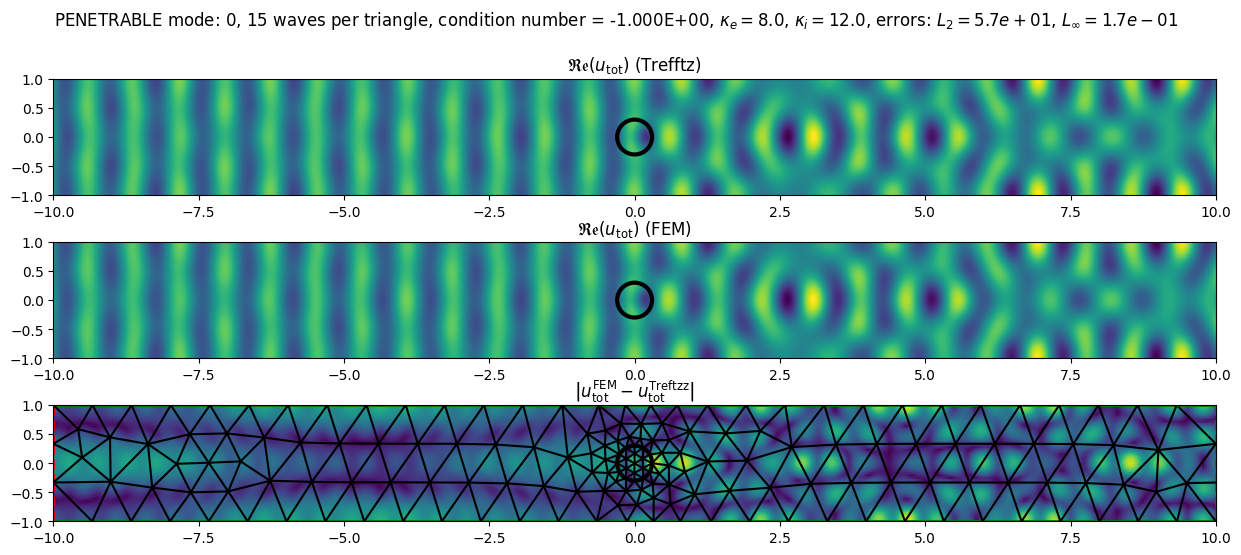

In [54]:
fig, ax = plt.subplots( nrows = 3, figsize=(15,6))


ax[0].imshow(np.real(u_Trefft), origin="lower", extent=[-R,R,-H,H])
ax[0].add_patch(Circle(xy=c,radius=rad, **kwargs))
#checkLabels(Edges, ax[0])
ax[0].axis('square')
ax[0].set_xlim([-R,R])
ax[0].set_ylim([-H,H])

diff = np.where( (X-c[0])**2 + (Y-c[1])**2> rad**2, np.abs(u_Trefft - u_test), 0.)

L2_err = np.sqrt(np.sum(diff**2)*(2*R*2*H))
L_inf_err = np.max(diff)


ax[1].imshow(np.real(u_test), origin="lower", extent=[-R,R,-H,H])
ax[1].add_patch(Circle(xy=c,radius=rad, **kwargs))

# checkLabels(Edges, ax[1])
ax[1].axis('square')
ax[1].set_xlim([-R,R])
ax[1].set_ylim([-H,H])



ax[2].imshow(np.abs(u_Trefft-u_test), origin="lower", extent=[-R,R,-H,H])

checkLabels(Edges, ax[2])
ax[2].add_patch(Circle(xy=c,radius=rad, **kwargs))

ax[2].axis('square')
ax[2].set_xlim([-R,R])
ax[2].set_ylim([-H,H])

match scatterer_type:
    case ScattererType.SOUND_HARD | ScattererType.SOUND_SOFT:
        fig.suptitle(f'{scatterer_type.name} mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\infty={L_inf_err:.1e}$')
        ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Trefftz)')
        ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (FEM)')
        ax[2].set_title('$\\left\\vert u^\\mathrm{FEM}_\\mathrm{tot}-u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')

    case  ScattererType.PENETRABLE:
        fig.suptitle(f'{scatterer_type.name} mode: {t}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa_e={kappa_e:.1f}$, $\\kappa_i={kappa_i:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\infty={L_inf_err:.1e}$')
        ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Trefftz)')
        ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (FEM)')
        ax[2].set_title('$\\left\\vert u^\\mathrm{FEM}_\\mathrm{tot}-u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')


    case ScattererType.GREEN_FUNC:
        fig.suptitle(f'{scatterer_type.name}, {Nth} waves per triangle, condition number = {Ncond: .3E}, $\\kappa={kappa_e:.1f}$, errors: $L_2={L2_err:.1e}$, $L_\\infty={L_inf_err:.1e}$')
        ax[0].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Trefftz)')
        ax[1].set_title('$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$ (Green function)')
        ax[2].set_title('$\\left\\vert G -u^\\mathrm{Treftzz}_\\mathrm{tot}\\right\\vert$')


save = False
if save:
    plt.savefig(f'mode_{t}_{Nth}_no_d2_no_wave_in_basis.png')

Text(0.5, 1.0, '$\\left|u_\\mathrm{tot}^\\mathrm{Trefftz}(-R,y)-u_\\mathrm{tot}^\\mathrm{FEM}(-R,y)\\right|$')

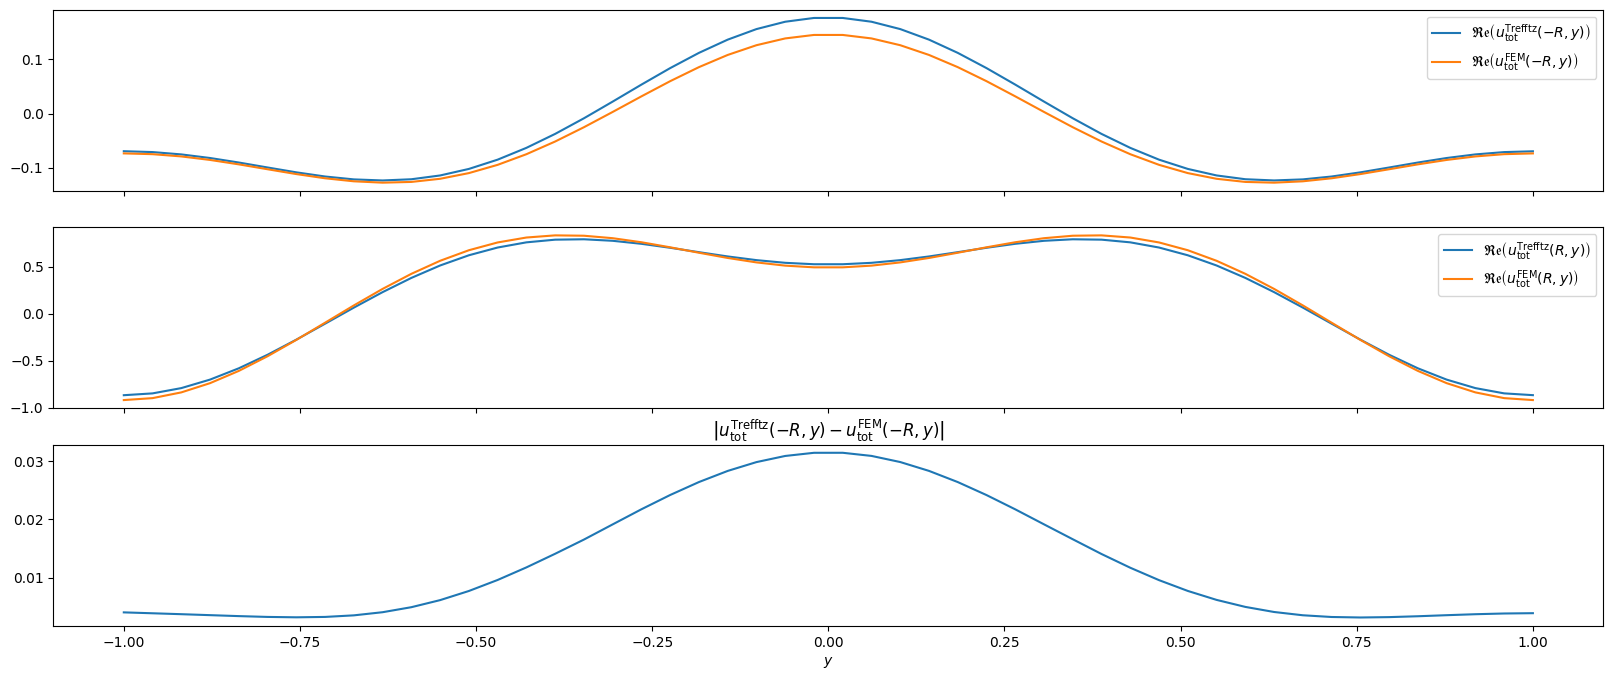

In [49]:
fig, ax = plt.subplots(nrows=3, figsize=(20,8), sharex=True)

ax[0].plot(y,np.real(u_Trefft[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}^\\mathrm{Trefftz}(-R,y)\\right)$')
ax[0].plot(y,np.real(u_test[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}^\\mathrm{FEM}(-R,y)\\right)$')
ax[0].legend()

ax[1].plot(y,np.real(u_Trefft[:,-1]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}^\\mathrm{Trefftz}(R,y)\\right)$')
ax[1].plot(y,np.real(u_test[:,-1]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}^\\mathrm{FEM}(R,y)\\right)$')
ax[1].legend()

ax[2].plot(y,np.real(u_Trefft[:,0] - u_test[:,0]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}\\right)$')
ax[2].set_xlabel('$y$')
ax[2].set_title('$\\left|u_\\mathrm{tot}^\\mathrm{Trefftz}(-R,y)-u_\\mathrm{tot}^\\mathrm{FEM}(-R,y)\\right|$')
# plt.legend()


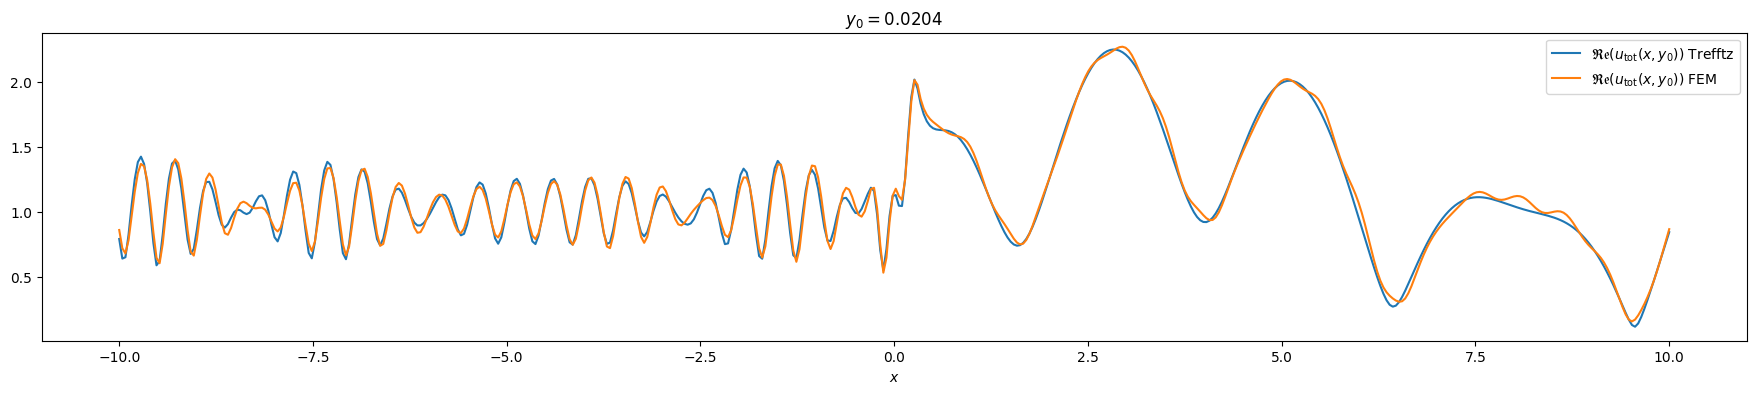

In [50]:
j=25
vmin = -3
vmax = 3
fig, ax = plt.subplots(figsize=(22,4))
ax.plot(x,np.abs(u_Trefft[j,:]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}(x,y_0)\\right)$ Trefftz')
ax.plot(x,np.abs(u_test[j,:]), label='$\\mathfrak{Re}\\left(u_\\mathrm{tot}(x,y_0)\\right)$ FEM')
ax.set_xlabel('$x$')
ax.set_title(f'$y_0={y[j]:.4f}$')
plt.legend()


In [164]:
# T = 5
# fps = 20
# Nt = int(fps*T)
# t_ = np.linspace(0,T,Nt)
# w = 2*np.pi*1/1

# vmin = -3
# vmax = 3
# for n in range(Nt):
#     fig, ax = plt.subplots( figsize=(15,3))

#     ax.imshow(np.real(Z*np.exp(-1j*w*t_[n])), origin="lower", vmin=vmin, vmax=vmax, extent=[-R,R,-H,H], interpolation='bilinear', cmap='Blues')
#     ax.axis('square')
#     ax.set_xlim([-R,R])
#     ax.set_ylim([-H,H])
#     ax.set_title(f'mode number: {t}, {Nth} plane waves per triangle, $\\kappa={kappa_e:.1f}$, $t = \\mathtt{{{t_[n]:.2f}}}$')
#     ax.add_patch(Circle(xy=c,radius=rad, **kwargs))

#     plt.savefig(f'./r02_t1/{n:02d}.png',dpi=200)
#     plt.close()

In [53]:
scatterer_type.name

'PENETRABLE'